In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install --upgrade tensorflow
!pip install tensorflow-addons

     |████████████████████████████████| 394.3MB 34kB/s 
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa

import time
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11884058159185152900]

In [ ]:
train_man = np.load("/content/gdrive/My Drive/남자 여자 얼굴 transfer/man.npy")
train_woman = np.load("/content/gdrive/My Drive/남자 여자 얼굴 transfer/woman.npy")

In [ ]:
train_man = train_man.reshape(-1, 1, 128, 128, 3)
train_woman = train_woman.reshape(-1, 1, 128, 128, 3)

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
CHANNEL = 3
length = len(train_man)

In [ ]:
def generator():
  def downsample(layer_input, filters, f_size=3, stride= 2, activation='relu'):
    d = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=stride, padding='same')(layer_input)
    d = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(d)
    d = tf.keras.layers.Activation(activation)(d)

    return d
  
  def upsample(layer_input, filters, f_size=3):
    u = tf.keras.layers.UpSampling2D(size=2)(layer_input)
    #u = tf.keras.layers.Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(u)
    u = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(u)
    u = tf.keras.layers.Activation('relu')(u)

    return u

  def residual(layer_input, filters):
    shortcut = layer_input
    r = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(layer_input)
    r = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(r)
    r = tf.keras.layers.Activation('relu')(r)

    r = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(r)
    r = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(r)

    return tf.keras.layers.Concatenate()([shortcut, r])

  
  img = tf.keras.Input(shape=[IMG_WIDTH, IMG_HEIGHT, CHANNEL])
  d1 = downsample(img, 32, f_size=7, stride=1)
  d2 = downsample(d1, 64)
  d3 = downsample(d2, 128)
  r1 = residual(d3, 256)
  r2 = residual(r1, 512)
  r3 = residual(r2, 512)
  r4 = residual(r3, 512)
  r5 = residual(r4, 512)
  r6 = residual(r5, 512)
  r7 = residual(r6, 512)
  u1 = upsample(r7, 256)
  u2 = upsample(u1,128)
  d4 = downsample(u2, 128, f_size=7, stride=1)

  output = tf.keras.layers.Conv2D(CHANNEL, kernel_size=4, strides=1, padding='same', activation='tanh')(d4)

  return tf.keras.models.Model(img, output)

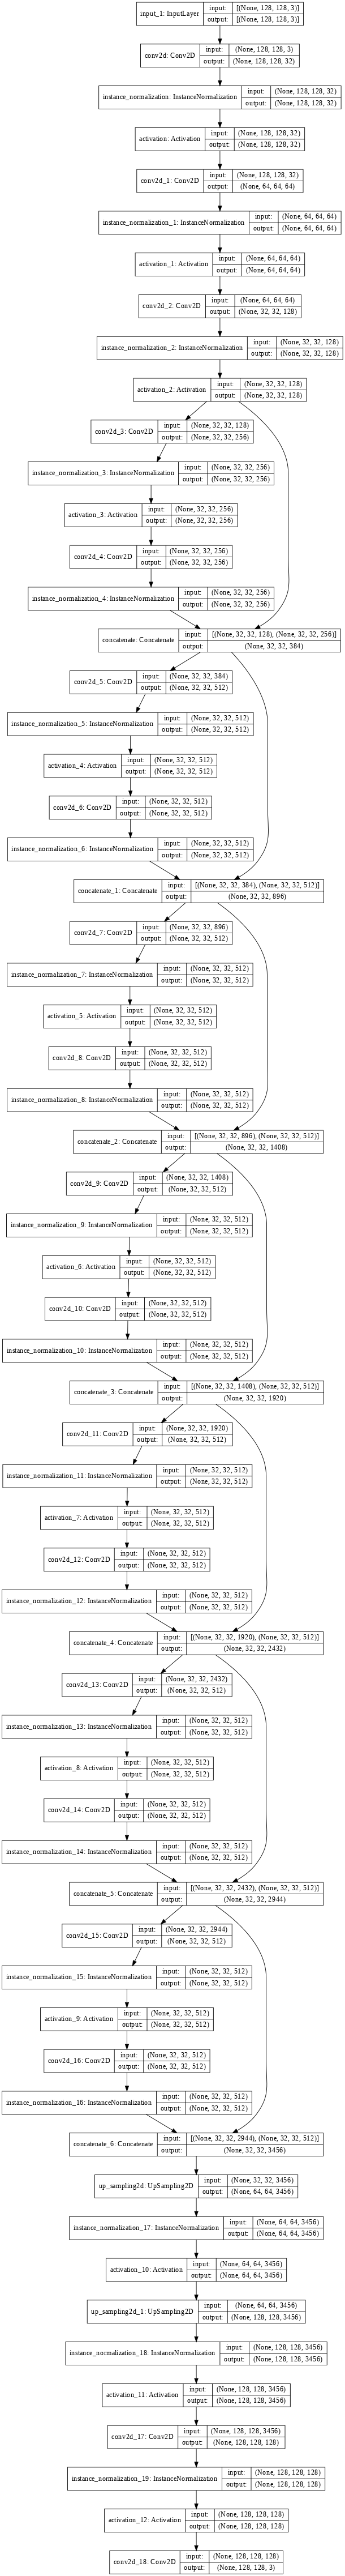

In [ ]:
tf.keras.utils.plot_model(generator(), show_shapes=True, dpi=64)

In [ ]:
def discriminator():
  def conv4(layer_input, filters, stride = 2, norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    y = tf.keras.layers.Conv2D(filters, kernel_size=4, strides=stride, padding='same')(layer_input)

    if norm:
      y = tfa.layers.InstanceNormalization(axis=-1, center=False, scale=False)(y)
    
    y = tf.keras.layers.LeakyReLU(0.2)(y)

    return y
  
  img = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, CHANNEL))

  y = conv4(img, 64, stride = 2, norm = False)
  y = conv4(y, 128, stride = 2)
  y = conv4(y, 256, stride = 2)

  output = tf.keras.layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(y)

  return tf.keras.models.Model(img, output)

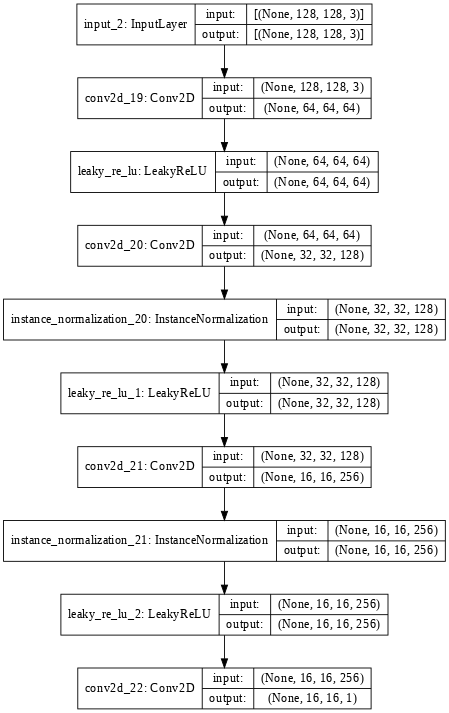

In [ ]:
tf.keras.utils.plot_model(discriminator(), show_shapes=True, dpi=64)

In [ ]:
discriminator_man = discriminator()
discriminator_woman = discriminator()

generator_man2woman = generator()
generator_woman2man = generator()

Adam = tf.keras.optimizers.Adam(2e-4, 0.5)

generator_man2woman_optimizer = Adam
generator_woman2man_optimizer = Adam

discriminator_man2woman_optimizer = Adam
discriminator_woman2man_optimizer = Adam

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
def generate_images(man2woman, woman2man, man, woman):
  prediction_man2woman = man2woman(man)
  prediction_woman2man = woman2man(woman)
  
  reconstructed_man = woman2man(prediction_man2woman)
  reconstructed_woman = man2woman(prediction_woman2man)

  plt.figure(figsize=(18,18))

  display_list_man = [man, prediction_man2woman, reconstructed_man]
  display_list_woman = [woman, prediction_woman2man, reconstructed_woman]
  title_man = ['Man', 'Predicted Image', 'Reconstucted Image']
  title_woman = ['Woman', 'Predicted Image', 'Reconstucted Image']

  f, ax = plt.subplots(nrows=1, ncols=3)
  for i in range(len(display_list_man)):
    ax[i].set_title(title_man[i])
    ax[i].imshow(display_list_man[i][0] * 0.5 + 0.5)

  f, ax = plt.subplots(nrows=1, ncols=3)
  for i in range(len(display_list_woman)):
    ax[i].set_title(title_woman[i])
    ax[i].imshow(display_list_woman[i][0] * 0.5 + 0.5)

  plt.show()

In [ ]:
from PIL import Image

sample_woman = np.array(Image.open("/content/gdrive/My Drive/남자 여자 얼굴 transfer/Samples/woman.jpg"))
sample_woman = tf.cast(sample_woman, dtype=tf.float32)
sample_woman = (sample_woman / 127.5) - 1

sample_man = np.array(Image.open("/content/gdrive/MyDrive/남자 여자 얼굴 transfer/Samples/미루.png"))
sample_man = tf.cast(sample_man, dtype=tf.float32)
sample_man = (sample_man / 127.5) - 1

In [ ]:
sample_man, sample_woman = np.copy(tf.expand_dims(sample_man, 0)), np.copy(tf.expand_dims(sample_woman, 0))

In [ ]:
# sample_man = np.copy(tf.expand_dims(sample_man, 0))

In [ ]:
import PIL.Image

sample_man = PIL.Image.open("/content/gdrive/MyDrive/남자 여자 얼굴 transfer/Samples/미루.png")
sample_man = sample_man.convert('RGB')

In [ ]:
sample_man = np.array(sample_man)

In [ ]:
sample_man = sample_man.astype('float32')

In [ ]:
sample_man.shape

(128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


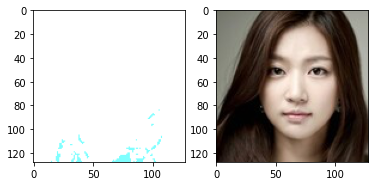

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(tf.squeeze(sample_man) * 0.5 + 0.5)
ax[1].imshow(tf.squeeze(sample_woman) * 0.5 + 0.5)
plt.show()

In [ ]:
checkpoint_path = "/content/gdrive/My Drive/남자 여자 얼굴 transfer/Saved Model"

ckpt = tf.train.Checkpoint(generator_woman2man=generator_woman2man,
                           generator_man2woman=generator_man2woman,
                           discriminator_man=discriminator_man,
                           discriminator_woman=discriminator_woman,
                           generator_woman2man_optimizer=generator_woman2man_optimizer,
                           generator_man2woman_optimizer=generator_man2woman_optimizer,
                           discriminator_man2woman_optimizer=discriminator_man2woman_optimizer,
                           discriminator_woman2man_optimizer=discriminator_woman2man_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
LAMBDA = 10

In [ ]:
sample_woman = np.array(Image.open("/content/gdrive/My Drive/남자 여자 얼굴 transfer/Samples/woman.jpg"))
sample_woman = tf.cast(sample_woman, dtype=tf.float32)
sample_woman = (sample_woman / 127.5) - 1

In [ ]:
sample_woman = tf.image.resize(sample_woman, [128+15, 128+15],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


sample_man = tf.image.resize(sample_man, [128+15, 128+15],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def random_jitter(image):
  cropped_image1 = tf.image.random_crop(
      image, size=[128, 128, 3])
  return cropped_image1


  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
sample_woman = tf.squeeze(sample_woman)
sample_man = tf.squeeze(sample_man)

In [ ]:
@tf.function
def train_step(real_man, real_woman, trainable=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    # 이미지의 사이즈를 128 -> 224 다음 랜던으로 크롭해서 다시 224 -> 128로 맞춰서 데이터를 넣어주는거임

    # real_woman = real_woman.reshape(-1, 1, 224, 224, 3)
    # real_man = real_man.reshape(-1, 1, 224, 224, 3)

    # def random_crop(fake_woamn):
    #   cropped_fake_woman = tf.fake_woman.random_crop(fake_woman, size=[128, 128, 3])
    #   return cropped_image

    # def random_crop(fake_man):
    #   cropped_fake_man = tf.fake_man.random_crop(fake_man, size=[128, 128, 3])

    #   return cropped_image

    real_woman = tf.image.resize(real_woman, [128+15, 128+15],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


    real_man = tf.image.resize(real_man, [128+15, 128+15],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


    def random_jitter(image):
      cropped_image1 = tf.image.random_crop(image, size=[1, 128, 128, 3])
      return cropped_image1


      image = tf.image.random_flip_left_right(image)

      return image
    
    real_man = random_jitter(real_man)
    real_woman = random_jitter(real_woman)

    fake_woman = generator_man2woman(real_man, training=trainable)
    cycled_man = generator_woman2man(fake_woman, training=trainable)

    fake_man = generator_woman2man(real_woman, training=trainable)
    cycled_woman = generator_man2woman(fake_man, training=trainable)

    # same_x and same_y are used for identity loss.
    real_man_id = generator_woman2man(real_man, training=trainable)
    real_woman_id = generator_man2woman(real_woman, training=trainable)

    disc_real_man = discriminator_man(real_man, training=trainable)
    disc_real_woman = discriminator_woman(real_woman, training=trainable)

    disc_fake_man = discriminator_man(fake_man, training=trainable)
    disc_fake_woman = discriminator_woman(fake_woman, training=trainable)

    # calculate the loss
    gen_man2woman_loss = generator_loss(disc_fake_woman)
    gen_woman2man_loss = generator_loss(disc_fake_man)
    
    total_cycle_loss = calc_cycle_loss(real_man, cycled_man) + calc_cycle_loss(real_woman, cycled_woman)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_man2woman_loss = gen_man2woman_loss + total_cycle_loss + identity_loss(real_woman, real_woman_id)
    total_gen_woman2man_loss = gen_woman2man_loss + total_cycle_loss + identity_loss(real_man, real_man_id)

    disc_man_loss = discriminator_loss(disc_real_man, disc_fake_man)
    disc_woman_loss = discriminator_loss(disc_real_woman, disc_fake_woman)
  
    loss = [gen_man2woman_loss, gen_woman2man_loss, disc_man_loss, disc_woman_loss]

  if trainable:
    # Calculate the gradients for generator and discriminator
    generator_woman2man_gradients = tape.gradient(total_gen_woman2man_loss, 
                                          generator_woman2man.trainable_variables)
    generator_man2woman_gradients = tape.gradient(total_gen_man2woman_loss, 
                                          generator_man2woman.trainable_variables)

    discriminator_man_gradients = tape.gradient(disc_man_loss, 
                                              discriminator_man.trainable_variables)
    discriminator_woman_gradients = tape.gradient(disc_woman_loss, 
                                              discriminator_woman.trainable_variables)

    # Apply the gradients to the optimizer
    generator_woman2man_optimizer.apply_gradients(zip(generator_woman2man_gradients, 
                                              generator_woman2man.trainable_variables))

    generator_man2woman_optimizer.apply_gradients(zip(generator_man2woman_gradients, 
                                              generator_man2woman.trainable_variables))

    discriminator_man2woman_optimizer.apply_gradients(zip(discriminator_man_gradients,
                                                  discriminator_man.trainable_variables))

    discriminator_woman2man_optimizer.apply_gradients(zip(discriminator_woman_gradients,
                                                  discriminator_woman.trainable_variables))

  return loss

In [ ]:
sample_man.shape

TensorShape([143, 143, 4])

In [ ]:
np.random.shuffle(train_man)
np.random.shuffle(train_woman)

In [ ]:
train_man[0].shape

(1, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1296x1296 with 0 Axes>

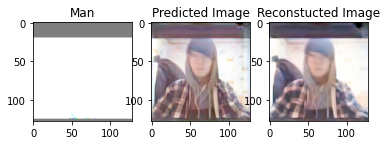

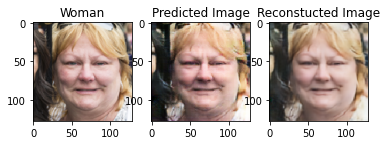

In [ ]:
generate_images(generator_man2woman, generator_woman2man, sample_man.reshape(1, 128, 128, 3), train_woman[50].reshape(1, 128, 128, 3))

In [ ]:
#generate_images(generator_man2woman, generator_woman2man, sample_man, sample_woman)

In [ ]:
from IPython.display import clear_output
import math

In [ ]:
bs = 32

In [ ]:
train_man, train_woman = train_man.reshape(-1, IMG_WIDTH, IMG_HEIGHT, CHANNEL), train_woman.reshape(-1, IMG_WIDTH, IMG_HEIGHT, CHANNEL)

<Figure size 1296x1296 with 0 Axes>

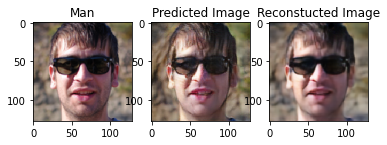

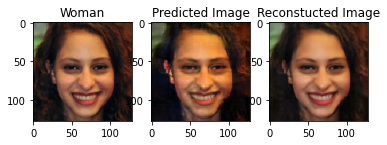

man2woman loss :  tf.Tensor(1.1425376, shape=(), dtype=float32)
woman2man loss :  tf.Tensor(2.4290226, shape=(), dtype=float32)
man discriminator loss :  tf.Tensor(0.24211058, shape=(), dtype=float32)
woman discriminator loss :  tf.Tensor(0.62151337, shape=(), dtype=float32)


In [ ]:
for epoch in range(500):
  start = time.time()

  np.random.shuffle(train_man)
  np.random.shuffle(train_woman)

  for i in range(int(math.ceil(length / bs))):
    train_step(train_man[bs * i: bs * (i + 1)], train_woman[bs * i: bs * (i + 1)])
    
    if ( i % 200 == 0):
      print ("{}".format(i), end='')

  clear_output(wait=True)

  loss = train_step(tf.expand_dims(train_man[0], 0), tf.expand_dims(train_woman[0], 0), trainable=False)

  generate_images(generator_man2woman, generator_woman2man, tf.expand_dims(train_man[0], 0), tf.expand_dims(train_woman[0], 0))

  print("man2woman loss : ", loss[0])
  print("woman2man loss : ", loss[1])
  print("man discriminator loss : ", loss[2])
  print("woman discriminator loss : ", loss[3])

  if epoch % 20 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [ ]:
ckpt_save_path = ckpt_manager.save()